# Garbage Detection system



#Install Dependencies



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 12769, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 12769 (delta 77), reused 82 (delta 39), pack-reused 12633
Receiving objects: 100% (12769/12769), 12.89 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (8789/8789), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 145 kB 16.1 MB/s 
     |████████████████████████████████| 178 kB 65.4 MB/s 
     |████████████████████████████████| 1.1 MB 69.8 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 138 kB 33.8 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")
from roboflow import Roboflow
rf = Roboflow(api_key="92nKls8XVoI0maoBfh3n")
project = rf.workspace("university-of-hertfordshire").project("garbage-identification-system")
dataset = project.version(2).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to garbage-identification-system-2 in yolov5pytorch:: 100%|██████████| 2742/2742 [00:01<00:00, 1671.20it/s]


In [ ]:

%cat {dataset.location}/data.yaml

names:
- cardboard
- glass
- metal
- paper
- plastic
- trash
nc: 6
train: garbage-identification-system-2/train/images
val: garbage-identification-system-2/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector



In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/garbage-identification-system-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 88 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momen

# Evaluate Custom YOLOv5 Detector Performance

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

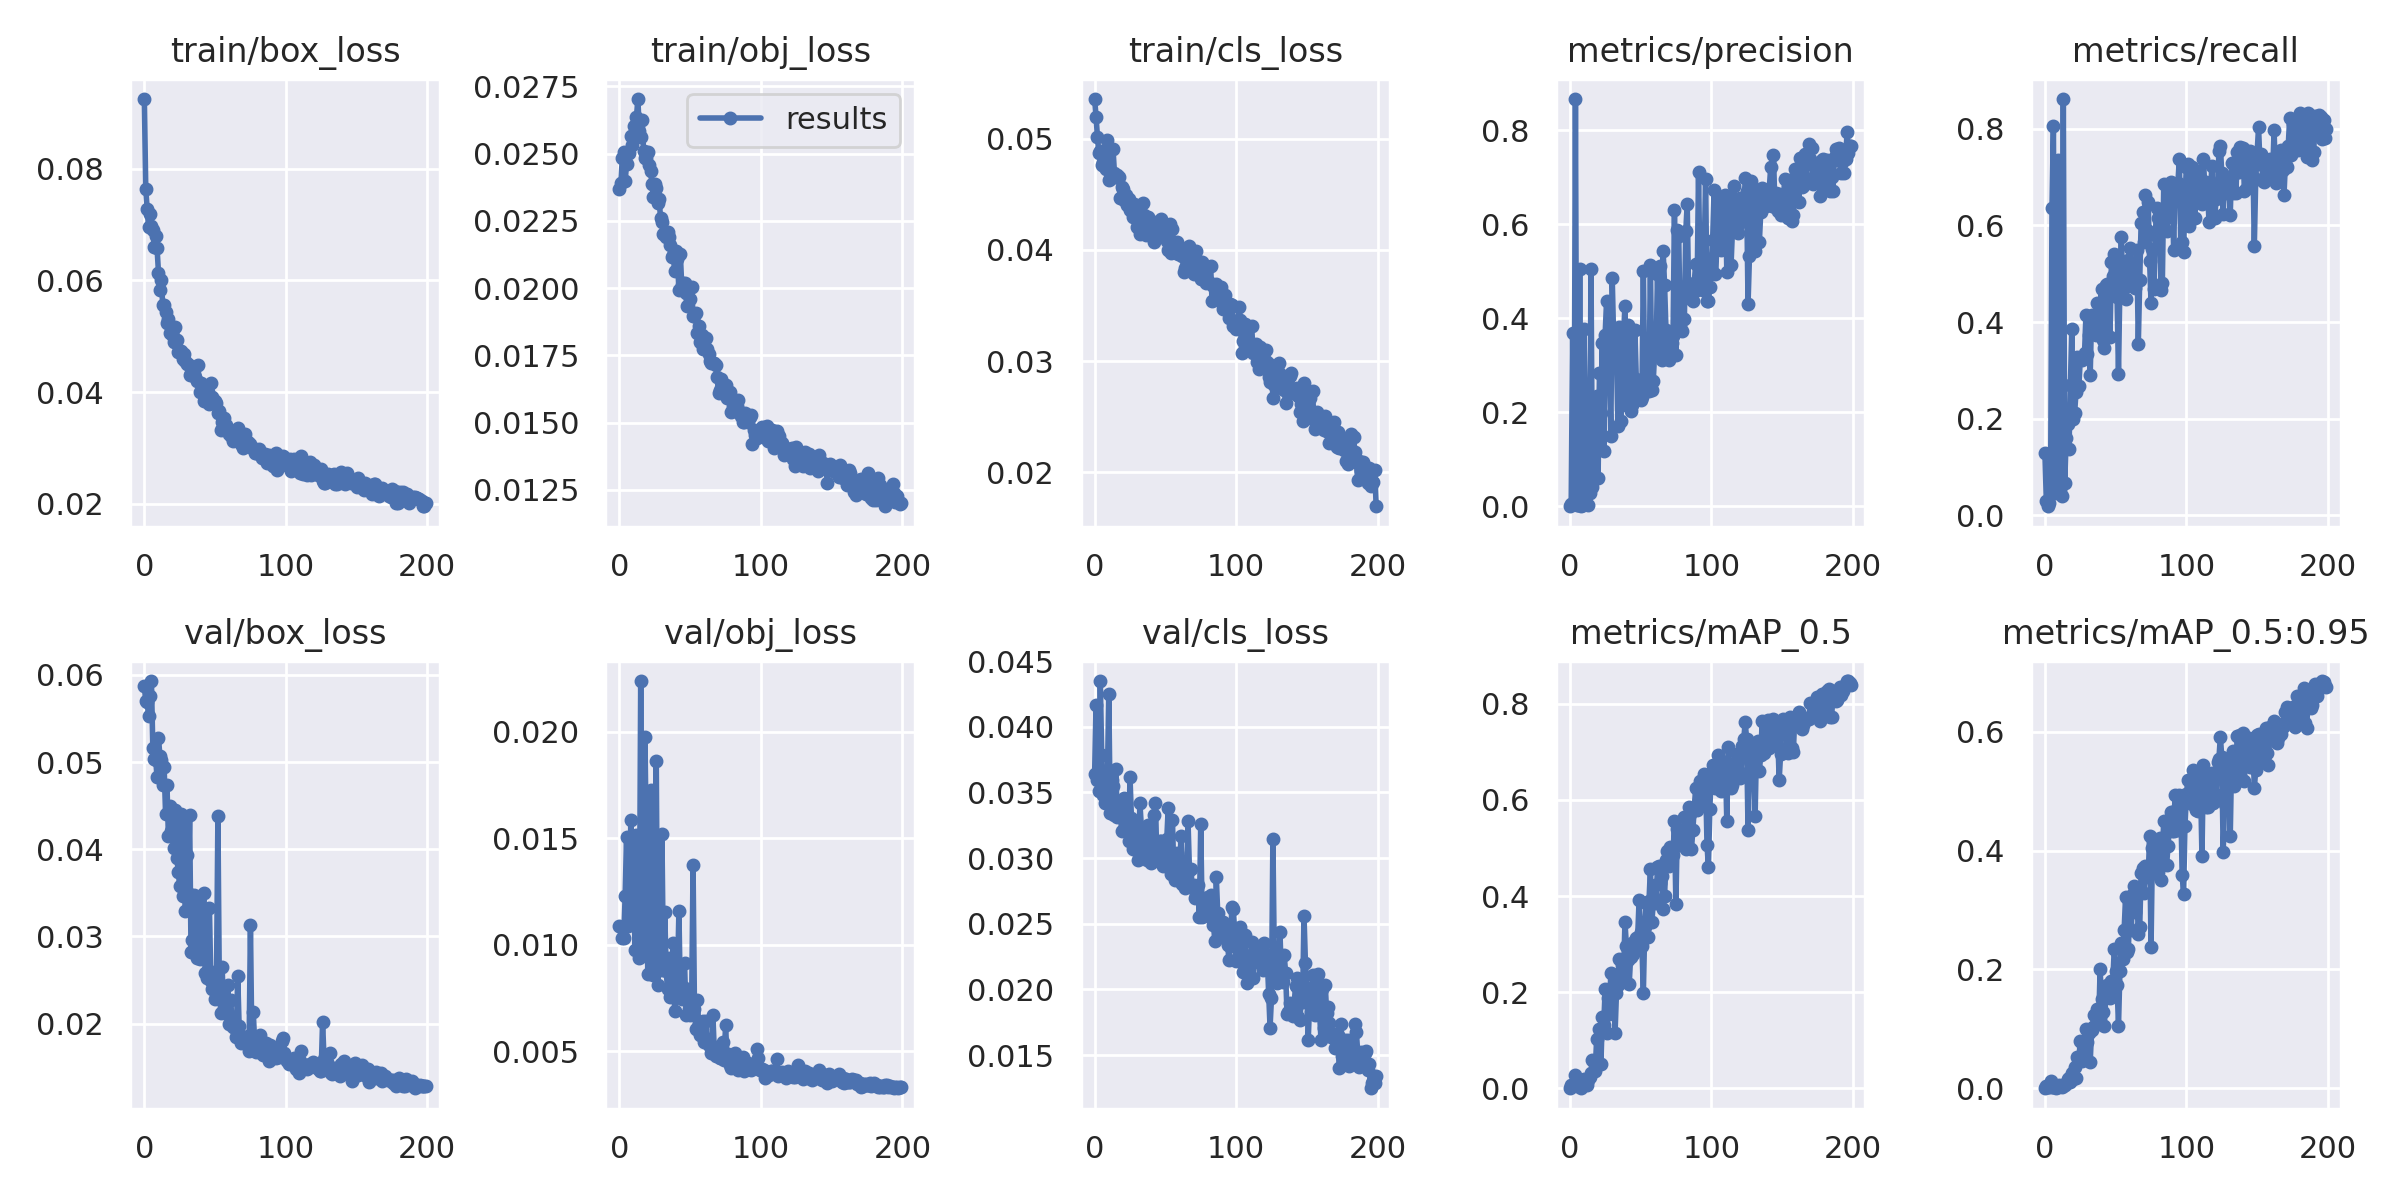

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [ ]:
ls

CONTRIBUTING.md                   hubconf.py    requirements.txt  utils/
data/                             LICENSE       runs/             val.py
detect.py                         models/       setup.cfg
export.py                         __pycache__/  train.py
garbage-identification-system-2/  README.md     tutorial.ipynb


GROUND TRUTH TRAINING DATA:


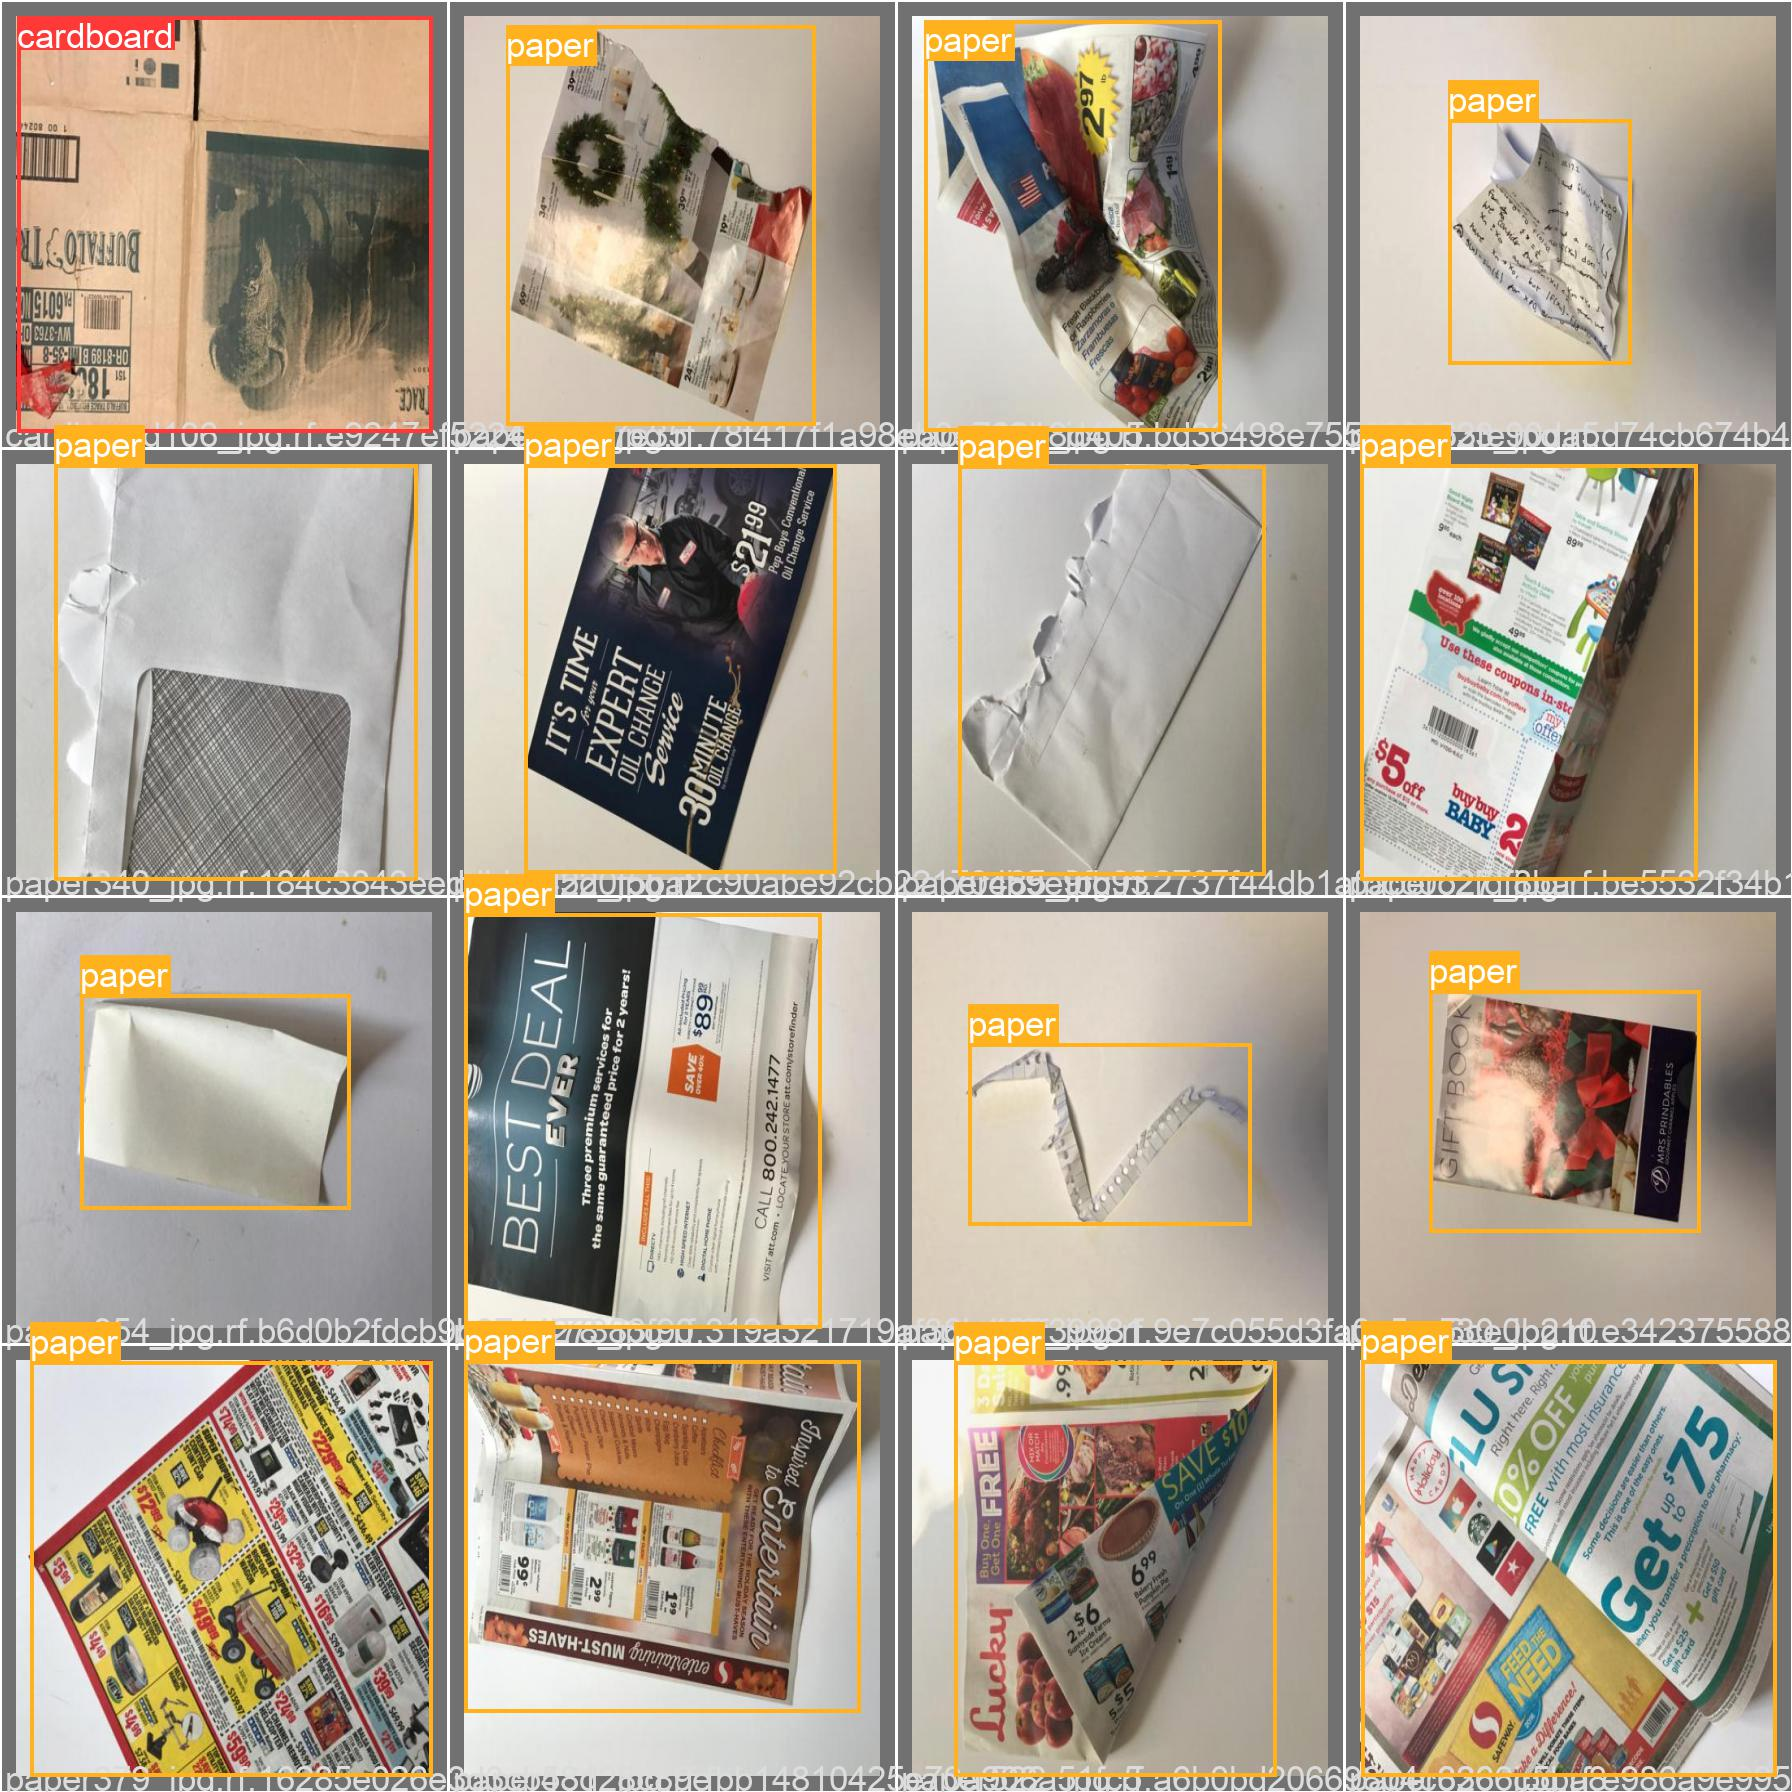

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


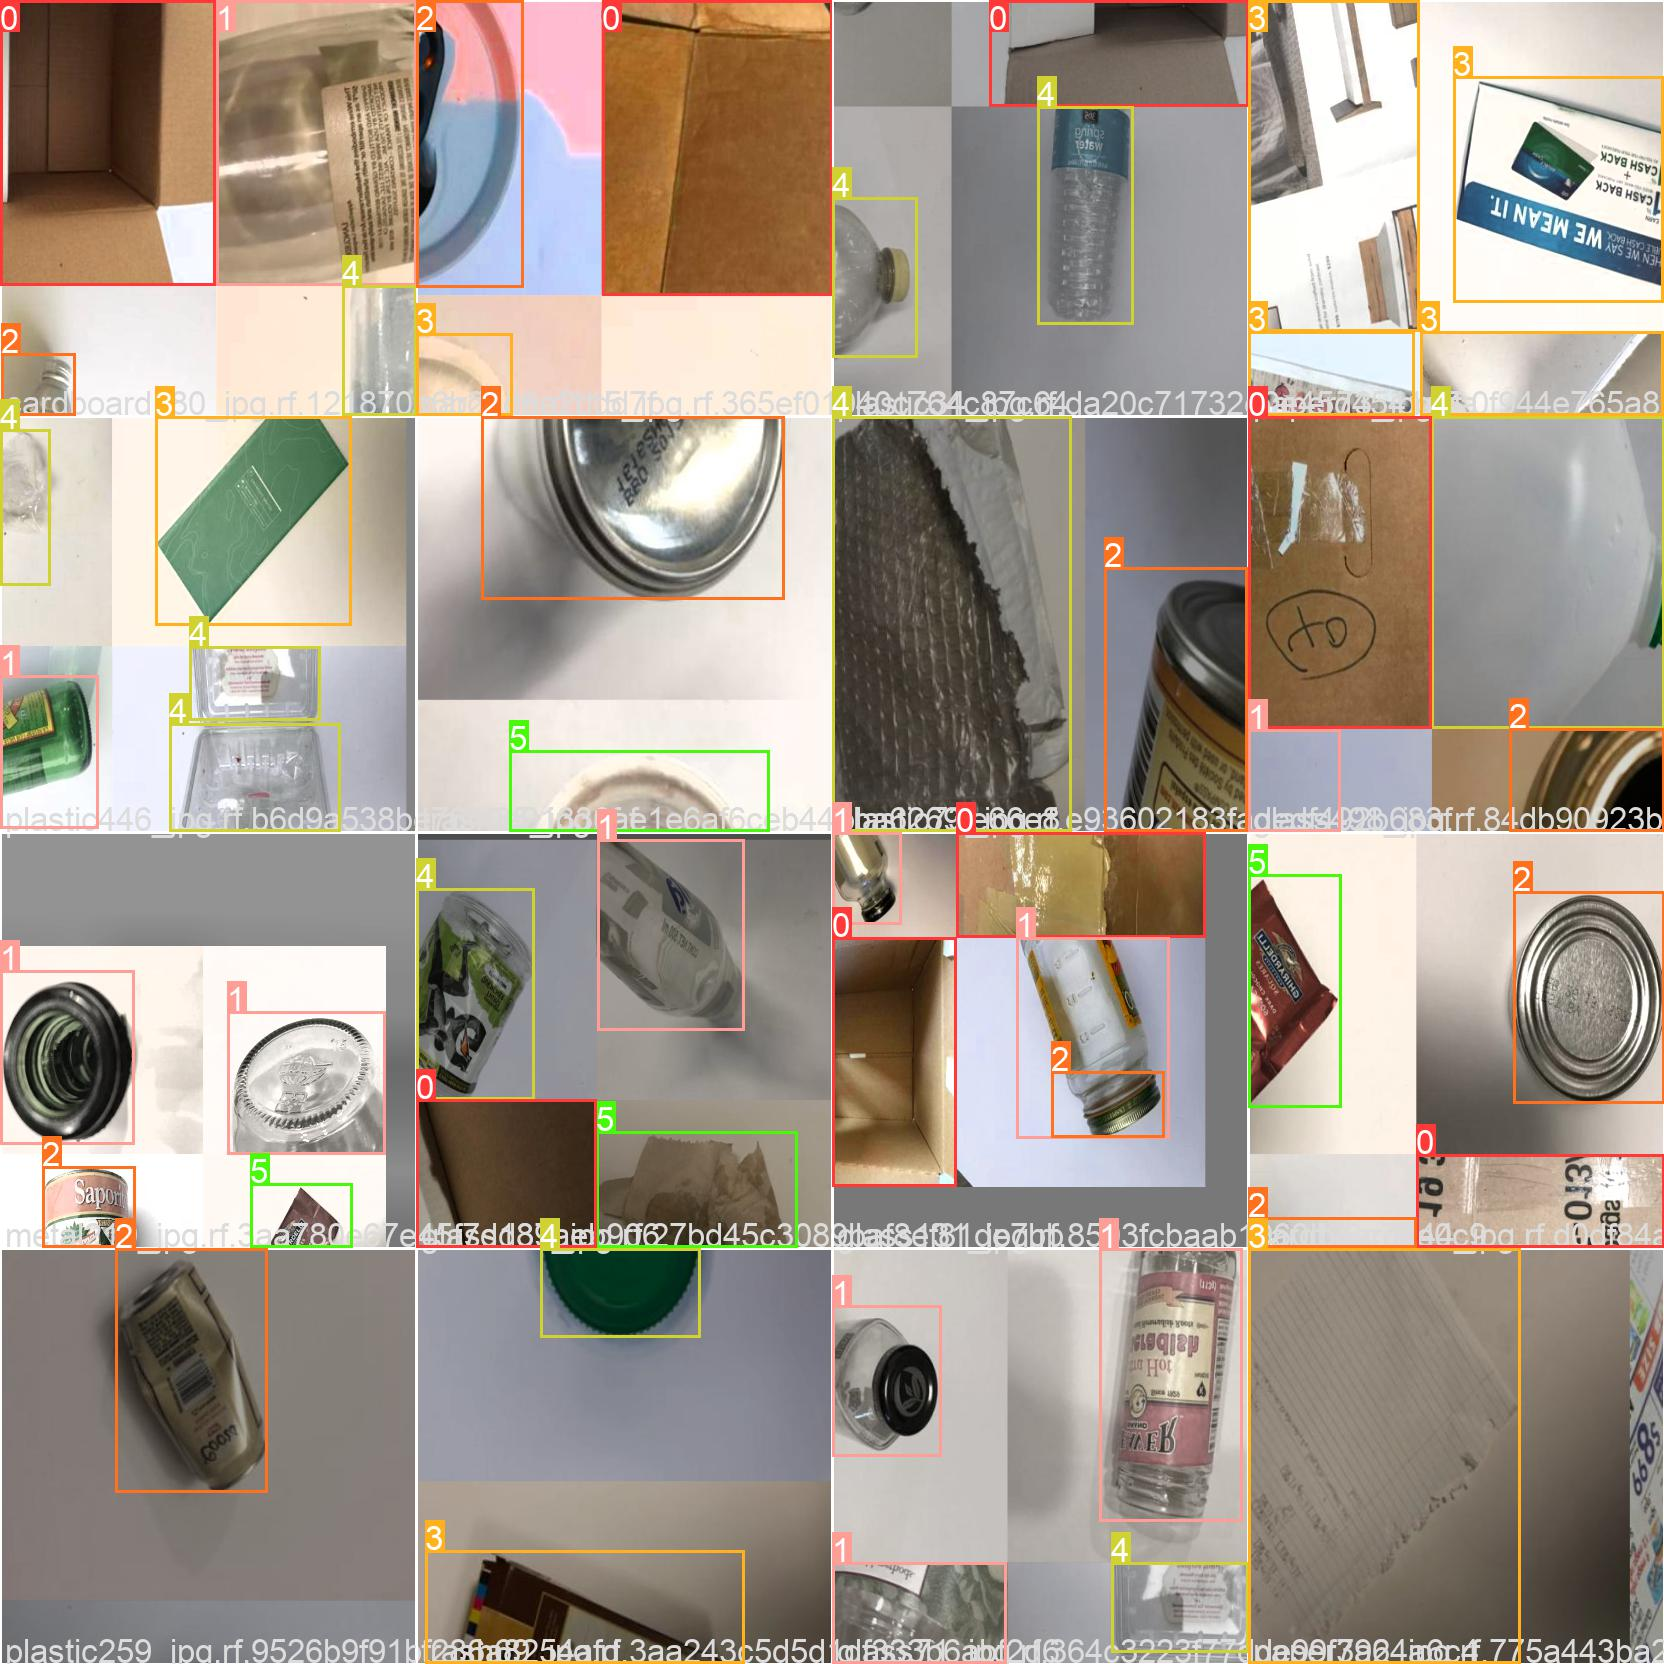

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../images

[Errno 2] No such file or directory: '/content/yolov5/'
/content/gdrive/MyDrive/Colab Notebooks/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/gdrive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-8-15 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7260003 parameters, 0 gradients, 16.8 GFLOPs
image 1/11 /content/gdrive/MyDrive/Colab Notebooks/images/cardboard55.jpg: 320x416 1 cardboard, Done. (0.014s)
image 2/11 /content/gdrive/MyDrive/Colab Notebooks/images/car

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Colab Notebooks/yolov5


/content/gdrive/MyDrive/Colab Notebooks/yolov5


In [ ]:
ls


best.onnx                         hubconf.py        setup.cfg
classes.txt                       LICENSE           train.py
CONTRIBUTING.md                   models/           tutorial.ipynb
data/                             __pycache__/      utils/
detect.py                         README.md         val.py
export.py                         requirements.txt  xxx.jpeg
garbage-identification-system-2/  runs/


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 1.6 MB 4.8 MB/s 
     |████████████████████████████████| 145 kB 4.7 MB/s 
     |████████████████████████████████| 178 kB 42.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.2 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 138 kB 74.4 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../images

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/gdrive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-8-15 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7260003 parameters, 0 gradients, 16.8 GFLOPs
image 1/11 /content/gdrive/MyDrive/Colab Notebooks/images/cardboard55.jpg: 320x416 1 cardboard, Done. (0.014s)
image 2/11 /content/gdrive/MyDrive/Colab Notebooks/images/cardboard94.jpg: 320x416 2 cardboards, Done. (0.009s)
image 3/11 /content/gdrive/MyDrive/Colab Notebooks/i

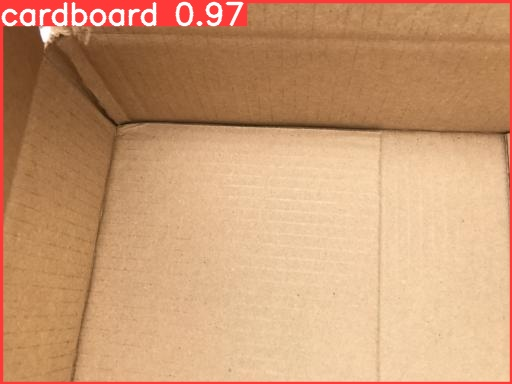

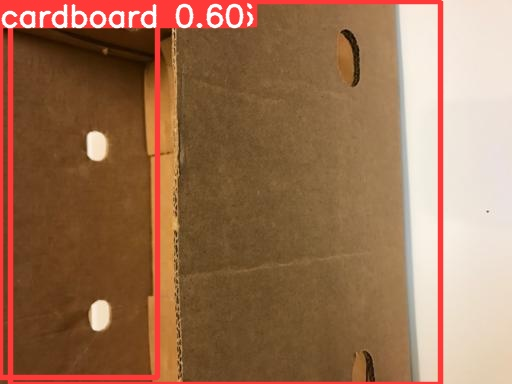

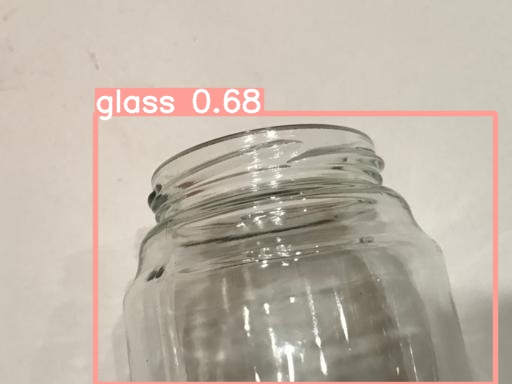

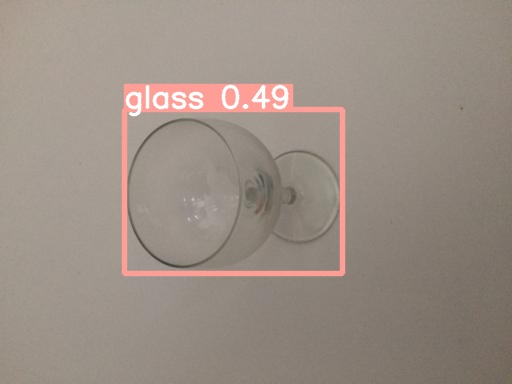

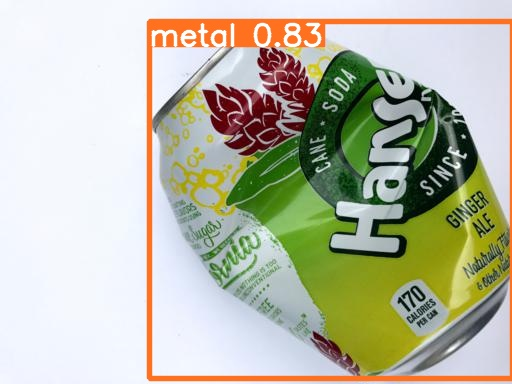

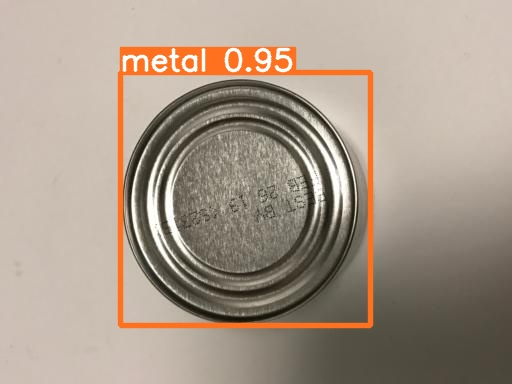

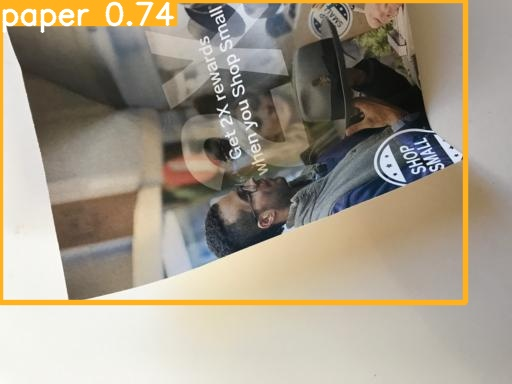

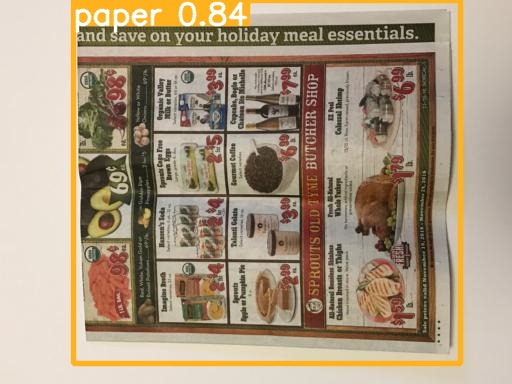

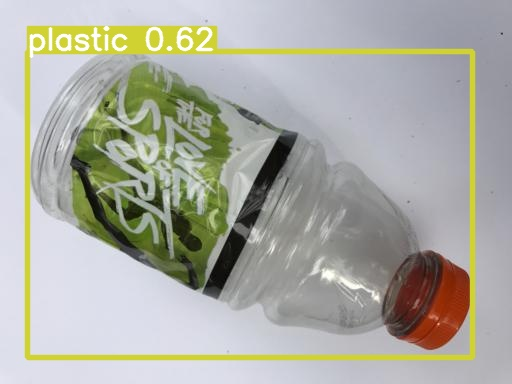

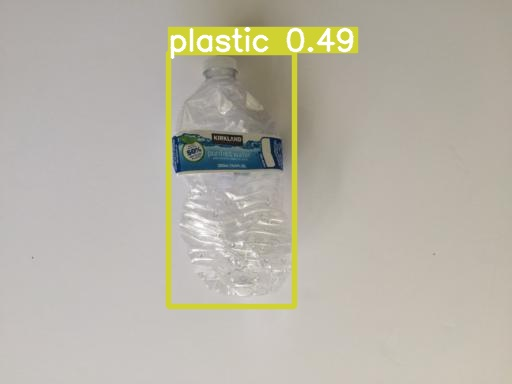

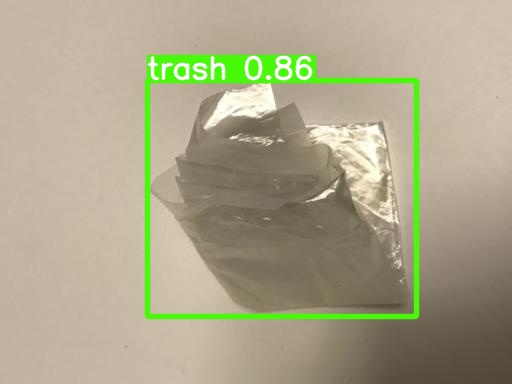

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/gdrive/MyDrive/Colab Notebooks/yolov5/runs/detect/exp4/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")


## **To export**

In [ ]:
pip uninstall onnx --y


Found existing installation: onnx 1.12.0
Uninstalling onnx-1.12.0:
  Successfully uninstalled onnx-1.12.0


In [ ]:
pip install onnx==1.11.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.4 MB/s 


In [ ]:
onnx.__version__

'1.12.0'

In [ ]:
!python export.py --weights runs/train/yolov5s_results/weights/best.pt --include onnx --simplify


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
export: data=data/coco128.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
fatal: cannot change to '/content/gdrive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-8-15 Python-3.7.13 torch-1.11.0+cu102 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7260003 parameters, 0 gradients, 16.8 GFLOPs

PyTorch: starting from runs/train/yolov5s_results/weights/best.pt with output shape (1, 25200, 11) (14.2 MB)

ON

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive